In [1]:
#@title 1. Setup and Imports
# Vision Transformer (ViT) Implementation for CIFAR-10
# Based on "An Image is Worth 16x16 Words" (Dosovskiy et al., 2021)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
#@title 2. Data Preparation and Loading
print("="*60)
print("STEP 1: PREPARING CIFAR-10 DATASET")
print("="*60)

# Data augmentation and normalization
# CIFAR-10 statistics for normalization
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2470, 0.2435, 0.2616)

# Training transforms with augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
])

# Test transforms (no augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
])

# Load datasets
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train
)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)

# Create data loaders
batch_size = 128
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Classes in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")
print(f"Number of classes: {len(classes)}")
print(f"Batch size: {batch_size}")

STEP 1: PREPARING CIFAR-10 DATASET


100%|██████████| 170M/170M [00:04<00:00, 37.5MB/s]


Training samples: 50000
Test samples: 10000
Number of classes: 10
Batch size: 128


In [3]:
#@title 3. Vision Transformer Components
print("="*60)
print("STEP 2: BUILDING VISION TRANSFORMER COMPONENTS")
print("="*60)

class PatchEmbedding(nn.Module):
    """
    Split image into patches and embed them.

    Parameters:
    - img_size: Size of the input image (assumed square)
    - patch_size: Size of each patch (assumed square)
    - in_channels: Number of input channels (3 for RGB)
    - embed_dim: Dimension of patch embeddings
    """
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=192):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_dim = in_channels * patch_size * patch_size

        # Linear projection of flattened patches
        self.projection = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)',
                      p1=patch_size, p2=patch_size),
            nn.Linear(self.patch_dim, embed_dim)
        )

    def forward(self, x):
        x = self.projection(x)
        return x

class MultiHeadSelfAttention(nn.Module):
    """
    Multi-Head Self Attention module.
    """
    def __init__(self, embed_dim, num_heads=6, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.attn_dropout = nn.Dropout(dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape

        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_dropout(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_dropout(x)
        return x

class MLP(nn.Module):
    """
    MLP (Feed-Forward Network) with GELU activation.
    """
    def __init__(self, in_features, hidden_features=None, out_features=None, dropout=0.1):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features * 4

        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class TransformerEncoderBlock(nn.Module):
    """
    Transformer Encoder Block with residual connections and layer normalization.
    """
    def __init__(self, embed_dim, num_heads=6, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, embed_dim * mlp_ratio, dropout=dropout)

    def forward(self, x):
        # Attention block with residual
        x = x + self.attn(self.norm1(x))
        # MLP block with residual
        x = x + self.mlp(self.norm2(x))
        return x

print("ViT components defined: PatchEmbedding, MultiHeadSelfAttention, MLP, TransformerEncoderBlock")

STEP 2: BUILDING VISION TRANSFORMER COMPONENTS
ViT components defined: PatchEmbedding, MultiHeadSelfAttention, MLP, TransformerEncoderBlock


In [4]:
#@title 4. Vision Transformer (ViT) Model Assembly
print("="*60)
print("STEP 3: ASSEMBLING COMPLETE VISION TRANSFORMER")
print("="*60)

class VisionTransformer(nn.Module):
    """
    Vision Transformer for image classification.
    """
    def __init__(self,
                 img_size=32,
                 patch_size=4,
                 in_channels=3,
                 num_classes=10,
                 embed_dim=192,
                 depth=12,
                 num_heads=6,
                 mlp_ratio=4,
                 dropout=0.1,
                 emb_dropout=0.1):
        super().__init__()

        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(emb_dropout)

        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        self.initialize_weights()

    def initialize_weights(self):
        torch.nn.init.trunc_normal_(self.pos_embed, std=0.02)
        torch.nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        B = x.shape[0]

        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        cls_token = x[:, 0]
        x = self.head(cls_token)
        return x

print("VisionTransformer class defined.")

STEP 3: ASSEMBLING COMPLETE VISION TRANSFORMER
VisionTransformer class defined.


In [23]:
#@title 5. Model Configuration and Initialization
print("="*60)
print("STEP 4: CONFIGURING MODEL")
print("="*60)

# Model hyperparameters
config = {
    'img_size': 32,
    'patch_size': 4,
    'in_channels': 3,
    'num_classes': 10,
    'embed_dim': 256,
    'depth': 12,
    'num_heads': 16,
    'mlp_ratio': 4,
    'dropout': 0.1,
    'emb_dropout': 0.1
}

# Create model
model = VisionTransformer(**config).to(device)

# Calculate model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Number of patches: {(config['img_size'] // config['patch_size']) ** 2}")

STEP 4: CONFIGURING MODEL
Configuration:
  img_size: 32
  patch_size: 4
  in_channels: 3
  num_classes: 10
  embed_dim: 256
  depth: 12
  num_heads: 16
  mlp_ratio: 4
  dropout: 0.1
  emb_dropout: 0.1

Total parameters: 9,509,642
Trainable parameters: 9,509,642
Number of patches: 64


In [24]:
#@title 6. Training Setup (Loss, Optimizer, Scheduler)
print("="*60)
print("STEP 5: SETTING UP TRAINING")
print("="*60)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer with weight decay (AdamW)
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.05)

# Learning rate scheduler - Cosine Annealing with Warmup
class CosineWarmupScheduler:
    def __init__(self, optimizer, warmup_epochs, total_epochs, base_lr, min_lr=1e-6):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.base_lr = base_lr
        self.min_lr = min_lr

    def step(self, epoch):
        if epoch < self.warmup_epochs:
            lr = self.base_lr * (epoch + 1) / self.warmup_epochs
        else:
            progress = (epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
            lr = self.min_lr + (self.base_lr - self.min_lr) * 0.5 * (1 + math.cos(math.pi * progress))

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        return lr

# Training parameters
num_epochs = 100
warmup_epochs = 10
scheduler = CosineWarmupScheduler(optimizer, warmup_epochs, num_epochs, base_lr=5e-4)

print(f"Optimizer: AdamW")
print(f"Initial learning rate: 5e-4")
print(f"Weight decay: 0.05")
print(f"Scheduler: Cosine with {warmup_epochs} warmup epochs")
print(f"Training epochs: {num_epochs}")

STEP 5: SETTING UP TRAINING
Optimizer: AdamW
Initial learning rate: 5e-4
Weight decay: 0.05
Scheduler: Cosine with 10 warmup epochs
Training epochs: 100


In [25]:
#@title 7. Training and Evaluation Functions
print("="*60)
print("STEP 6: DEFINING TRAINING AND EVALUATION FUNCTIONS")
print("="*60)

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train model for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc='Training')
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        pbar.set_postfix({
            'loss': running_loss / (batch_idx + 1),
            'acc': 100. * correct / total
        })
    return running_loss / len(dataloader), 100. * correct / total

def evaluate(model, dataloader, criterion, device):
    """Evaluate model on test/validation set."""
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Evaluating')
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            pbar.set_postfix({
                'loss': test_loss / (batch_idx + 1),
                'acc': 100. * correct / total
            })
    return test_loss / len(dataloader), 100. * correct / total

print("train_epoch() and evaluate() functions defined.")

STEP 6: DEFINING TRAINING AND EVALUATION FUNCTIONS
train_epoch() and evaluate() functions defined.


In [26]:
#@title 8. Training Loop
print("="*60)
print("STEP 7: TRAINING THE MODEL")
print("="*60)

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': [],
    'lr': []
}

best_acc = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")

    current_lr = scheduler.step(epoch)
    print(f"Learning rate: {current_lr:.6f}")

    train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, testloader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    history['lr'].append(current_lr)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_vit_cifar10.pth')
        print(f"Best model saved! Test Acc: {best_acc:.2f}%")

print(f"\nTraining completed! Best Test Accuracy: {best_acc:.2f}%")

STEP 7: TRAINING THE MODEL

Epoch [1/100]
Learning rate: 0.000050


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.39it/s, loss=1.87, acc=32.2]


Train Loss: 1.8744, Train Acc: 29.83%
Test Loss: 1.8680, Test Acc: 32.23%
Best model saved! Test Acc: 32.23%

Epoch [2/100]
Learning rate: 0.000100


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.17it/s, loss=1.63, acc=41.8]


Train Loss: 1.6770, Train Acc: 37.84%
Test Loss: 1.6333, Test Acc: 41.83%
Best model saved! Test Acc: 41.83%

Epoch [3/100]
Learning rate: 0.000150


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.30it/s, loss=1.42, acc=49.4]


Train Loss: 1.4930, Train Acc: 45.55%
Test Loss: 1.4237, Test Acc: 49.38%
Best model saved! Test Acc: 49.38%

Epoch [4/100]
Learning rate: 0.000200


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.12it/s, loss=1.33, acc=52]


Train Loss: 1.3819, Train Acc: 49.93%
Test Loss: 1.3324, Test Acc: 51.95%
Best model saved! Test Acc: 51.95%

Epoch [5/100]
Learning rate: 0.000250


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.29it/s, loss=1.27, acc=53.7]


Train Loss: 1.3086, Train Acc: 52.55%
Test Loss: 1.2688, Test Acc: 53.66%
Best model saved! Test Acc: 53.66%

Epoch [6/100]
Learning rate: 0.000300


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.23it/s, loss=1.25, acc=55.2]


Train Loss: 1.2634, Train Acc: 54.51%
Test Loss: 1.2472, Test Acc: 55.23%
Best model saved! Test Acc: 55.23%

Epoch [7/100]
Learning rate: 0.000350


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.25it/s, loss=1.14, acc=58.6]


Train Loss: 1.2196, Train Acc: 56.05%
Test Loss: 1.1421, Test Acc: 58.56%
Best model saved! Test Acc: 58.56%

Epoch [8/100]
Learning rate: 0.000400


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.04it/s, loss=1.09, acc=60.6]


Train Loss: 1.1859, Train Acc: 57.31%
Test Loss: 1.0945, Test Acc: 60.60%
Best model saved! Test Acc: 60.60%

Epoch [9/100]
Learning rate: 0.000450


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.20it/s, loss=1.1, acc=60.8]


Train Loss: 1.1556, Train Acc: 58.45%
Test Loss: 1.0961, Test Acc: 60.77%
Best model saved! Test Acc: 60.77%

Epoch [10/100]
Learning rate: 0.000500


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.02it/s, loss=1.07, acc=60.6]


Train Loss: 1.1127, Train Acc: 60.36%
Test Loss: 1.0729, Test Acc: 60.57%

Epoch [11/100]
Learning rate: 0.000500


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.17it/s, loss=1.03, acc=63.5]


Train Loss: 1.0703, Train Acc: 61.79%
Test Loss: 1.0264, Test Acc: 63.54%
Best model saved! Test Acc: 63.54%

Epoch [12/100]
Learning rate: 0.000500


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.25it/s, loss=0.962, acc=65.9]


Train Loss: 1.0271, Train Acc: 63.32%
Test Loss: 0.9618, Test Acc: 65.87%
Best model saved! Test Acc: 65.87%

Epoch [13/100]
Learning rate: 0.000499


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.14it/s, loss=0.924, acc=67.7]


Train Loss: 0.9789, Train Acc: 64.92%
Test Loss: 0.9243, Test Acc: 67.66%
Best model saved! Test Acc: 67.66%

Epoch [14/100]
Learning rate: 0.000499


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.26it/s, loss=0.878, acc=68.9]


Train Loss: 0.9345, Train Acc: 66.80%
Test Loss: 0.8776, Test Acc: 68.89%
Best model saved! Test Acc: 68.89%

Epoch [15/100]
Learning rate: 0.000498


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.95it/s, loss=0.841, acc=70.5]


Train Loss: 0.8935, Train Acc: 68.28%
Test Loss: 0.8414, Test Acc: 70.50%
Best model saved! Test Acc: 70.50%

Epoch [16/100]
Learning rate: 0.000496


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.28it/s, loss=0.824, acc=71.2]


Train Loss: 0.8618, Train Acc: 69.35%
Test Loss: 0.8244, Test Acc: 71.24%
Best model saved! Test Acc: 71.24%

Epoch [17/100]
Learning rate: 0.000495


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.19it/s, loss=0.806, acc=71.4]


Train Loss: 0.8363, Train Acc: 70.45%
Test Loss: 0.8060, Test Acc: 71.36%
Best model saved! Test Acc: 71.36%

Epoch [18/100]
Learning rate: 0.000493


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.27it/s, loss=0.765, acc=73]


Train Loss: 0.8179, Train Acc: 70.89%
Test Loss: 0.7651, Test Acc: 72.98%
Best model saved! Test Acc: 72.98%

Epoch [19/100]
Learning rate: 0.000490


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.18it/s, loss=0.775, acc=72.9]


Train Loss: 0.7844, Train Acc: 72.30%
Test Loss: 0.7751, Test Acc: 72.89%

Epoch [20/100]
Learning rate: 0.000488


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.25it/s, loss=0.722, acc=74.8]


Train Loss: 0.7659, Train Acc: 72.79%
Test Loss: 0.7220, Test Acc: 74.77%
Best model saved! Test Acc: 74.77%

Epoch [21/100]
Learning rate: 0.000485


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.12it/s, loss=0.757, acc=73.1]


Train Loss: 0.7357, Train Acc: 74.05%
Test Loss: 0.7568, Test Acc: 73.11%

Epoch [22/100]
Learning rate: 0.000482


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.25it/s, loss=0.75, acc=73.3]


Train Loss: 0.7179, Train Acc: 74.69%
Test Loss: 0.7503, Test Acc: 73.30%

Epoch [23/100]
Learning rate: 0.000478


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.18it/s, loss=0.701, acc=75]


Train Loss: 0.6973, Train Acc: 75.18%
Test Loss: 0.7014, Test Acc: 75.03%
Best model saved! Test Acc: 75.03%

Epoch [24/100]
Learning rate: 0.000475


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.27it/s, loss=0.69, acc=75.5]


Train Loss: 0.6751, Train Acc: 76.01%
Test Loss: 0.6904, Test Acc: 75.54%
Best model saved! Test Acc: 75.54%

Epoch [25/100]
Learning rate: 0.000471


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.15it/s, loss=0.68, acc=76.7]


Train Loss: 0.6512, Train Acc: 76.98%
Test Loss: 0.6802, Test Acc: 76.69%
Best model saved! Test Acc: 76.69%

Epoch [26/100]
Learning rate: 0.000467


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.21it/s, loss=0.651, acc=77.3]


Train Loss: 0.6371, Train Acc: 77.54%
Test Loss: 0.6512, Test Acc: 77.26%
Best model saved! Test Acc: 77.26%

Epoch [27/100]
Learning rate: 0.000462


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.02it/s, loss=0.622, acc=78.2]


Train Loss: 0.6156, Train Acc: 78.08%
Test Loss: 0.6224, Test Acc: 78.22%
Best model saved! Test Acc: 78.22%

Epoch [28/100]
Learning rate: 0.000457


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.22it/s, loss=0.629, acc=77.9]


Train Loss: 0.6027, Train Acc: 78.55%
Test Loss: 0.6289, Test Acc: 77.87%

Epoch [29/100]
Learning rate: 0.000452


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.06it/s, loss=0.669, acc=76.6]


Train Loss: 0.5802, Train Acc: 79.32%
Test Loss: 0.6694, Test Acc: 76.56%

Epoch [30/100]
Learning rate: 0.000447


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.23it/s, loss=0.602, acc=79.4]


Train Loss: 0.5680, Train Acc: 80.00%
Test Loss: 0.6022, Test Acc: 79.40%
Best model saved! Test Acc: 79.40%

Epoch [31/100]
Learning rate: 0.000442


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.07it/s, loss=0.645, acc=77.9]


Train Loss: 0.5492, Train Acc: 80.53%
Test Loss: 0.6448, Test Acc: 77.92%

Epoch [32/100]
Learning rate: 0.000436


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.16it/s, loss=0.598, acc=79.5]


Train Loss: 0.5372, Train Acc: 80.82%
Test Loss: 0.5979, Test Acc: 79.54%
Best model saved! Test Acc: 79.54%

Epoch [33/100]
Learning rate: 0.000430


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.05it/s, loss=0.59, acc=79.7]


Train Loss: 0.5194, Train Acc: 81.44%
Test Loss: 0.5896, Test Acc: 79.67%
Best model saved! Test Acc: 79.67%

Epoch [34/100]
Learning rate: 0.000424


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.18it/s, loss=0.587, acc=80.2]


Train Loss: 0.5067, Train Acc: 82.02%
Test Loss: 0.5872, Test Acc: 80.18%
Best model saved! Test Acc: 80.18%

Epoch [35/100]
Learning rate: 0.000417


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 11.99it/s, loss=0.589, acc=80]


Train Loss: 0.4930, Train Acc: 82.57%
Test Loss: 0.5888, Test Acc: 80.01%

Epoch [36/100]
Learning rate: 0.000411


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.15it/s, loss=0.568, acc=81.1]


Train Loss: 0.4771, Train Acc: 83.00%
Test Loss: 0.5679, Test Acc: 81.07%
Best model saved! Test Acc: 81.07%

Epoch [37/100]
Learning rate: 0.000404


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.25it/s, loss=0.575, acc=80.3]


Train Loss: 0.4644, Train Acc: 83.45%
Test Loss: 0.5755, Test Acc: 80.35%

Epoch [38/100]
Learning rate: 0.000397


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.18it/s, loss=0.551, acc=81.5]


Train Loss: 0.4541, Train Acc: 83.67%
Test Loss: 0.5511, Test Acc: 81.46%
Best model saved! Test Acc: 81.46%

Epoch [39/100]
Learning rate: 0.000390


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.24it/s, loss=0.573, acc=80.9]


Train Loss: 0.4325, Train Acc: 84.63%
Test Loss: 0.5733, Test Acc: 80.90%

Epoch [40/100]
Learning rate: 0.000383


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.16it/s, loss=0.565, acc=80.8]


Train Loss: 0.4212, Train Acc: 85.10%
Test Loss: 0.5652, Test Acc: 80.78%

Epoch [41/100]
Learning rate: 0.000375


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.27it/s, loss=0.576, acc=80.7]


Train Loss: 0.4094, Train Acc: 85.20%
Test Loss: 0.5756, Test Acc: 80.74%

Epoch [42/100]
Learning rate: 0.000368


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.17it/s, loss=0.583, acc=81.1]


Train Loss: 0.3972, Train Acc: 85.75%
Test Loss: 0.5826, Test Acc: 81.08%

Epoch [43/100]
Learning rate: 0.000360


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.25it/s, loss=0.566, acc=81.3]


Train Loss: 0.3812, Train Acc: 86.43%
Test Loss: 0.5655, Test Acc: 81.34%

Epoch [44/100]
Learning rate: 0.000352


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.08it/s, loss=0.571, acc=81.6]


Train Loss: 0.3641, Train Acc: 87.05%
Test Loss: 0.5715, Test Acc: 81.64%
Best model saved! Test Acc: 81.64%

Epoch [45/100]
Learning rate: 0.000344


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.25it/s, loss=0.569, acc=81.9]


Train Loss: 0.3498, Train Acc: 87.45%
Test Loss: 0.5692, Test Acc: 81.88%
Best model saved! Test Acc: 81.88%

Epoch [46/100]
Learning rate: 0.000336


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.06it/s, loss=0.594, acc=81.5]


Train Loss: 0.3377, Train Acc: 87.85%
Test Loss: 0.5937, Test Acc: 81.53%

Epoch [47/100]
Learning rate: 0.000328


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.21it/s, loss=0.59, acc=81.3]


Train Loss: 0.3281, Train Acc: 88.27%
Test Loss: 0.5900, Test Acc: 81.35%

Epoch [48/100]
Learning rate: 0.000319


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.15it/s, loss=0.587, acc=81.7]


Train Loss: 0.3148, Train Acc: 88.63%
Test Loss: 0.5873, Test Acc: 81.71%

Epoch [49/100]
Learning rate: 0.000311


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.15it/s, loss=0.557, acc=82.9]


Train Loss: 0.2939, Train Acc: 89.42%
Test Loss: 0.5570, Test Acc: 82.91%
Best model saved! Test Acc: 82.91%

Epoch [50/100]
Learning rate: 0.000302


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.27it/s, loss=0.583, acc=81.9]


Train Loss: 0.2828, Train Acc: 89.76%
Test Loss: 0.5828, Test Acc: 81.94%

Epoch [51/100]
Learning rate: 0.000294


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.16it/s, loss=0.597, acc=81.9]


Train Loss: 0.2671, Train Acc: 90.37%
Test Loss: 0.5974, Test Acc: 81.92%

Epoch [52/100]
Learning rate: 0.000285


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.27it/s, loss=0.583, acc=82.6]


Train Loss: 0.2610, Train Acc: 90.66%
Test Loss: 0.5828, Test Acc: 82.57%

Epoch [53/100]
Learning rate: 0.000277


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.19it/s, loss=0.587, acc=82.6]


Train Loss: 0.2487, Train Acc: 91.05%
Test Loss: 0.5867, Test Acc: 82.63%

Epoch [54/100]
Learning rate: 0.000268


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.26it/s, loss=0.602, acc=82.5]


Train Loss: 0.2330, Train Acc: 91.61%
Test Loss: 0.6022, Test Acc: 82.53%

Epoch [55/100]
Learning rate: 0.000259


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.01it/s, loss=0.62, acc=82.4]


Train Loss: 0.2210, Train Acc: 91.89%
Test Loss: 0.6198, Test Acc: 82.36%

Epoch [56/100]
Learning rate: 0.000251


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.27it/s, loss=0.608, acc=82.8]


Train Loss: 0.2095, Train Acc: 92.36%
Test Loss: 0.6084, Test Acc: 82.77%

Epoch [57/100]
Learning rate: 0.000242


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.14it/s, loss=0.626, acc=82.8]


Train Loss: 0.2027, Train Acc: 92.64%
Test Loss: 0.6264, Test Acc: 82.83%

Epoch [58/100]
Learning rate: 0.000233


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.27it/s, loss=0.62, acc=82.4]


Train Loss: 0.1914, Train Acc: 93.19%
Test Loss: 0.6199, Test Acc: 82.36%

Epoch [59/100]
Learning rate: 0.000224


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.14it/s, loss=0.659, acc=82.4]


Train Loss: 0.1807, Train Acc: 93.44%
Test Loss: 0.6590, Test Acc: 82.43%

Epoch [60/100]
Learning rate: 0.000216


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.22it/s, loss=0.667, acc=82.6]


Train Loss: 0.1748, Train Acc: 93.66%
Test Loss: 0.6675, Test Acc: 82.57%

Epoch [61/100]
Learning rate: 0.000207


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.14it/s, loss=0.659, acc=82.7]


Train Loss: 0.1634, Train Acc: 94.08%
Test Loss: 0.6594, Test Acc: 82.70%

Epoch [62/100]
Learning rate: 0.000199


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.14it/s, loss=0.694, acc=82.4]


Train Loss: 0.1554, Train Acc: 94.46%
Test Loss: 0.6936, Test Acc: 82.37%

Epoch [63/100]
Learning rate: 0.000190


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.19it/s, loss=0.677, acc=82.9]


Train Loss: 0.1435, Train Acc: 94.73%
Test Loss: 0.6774, Test Acc: 82.91%

Epoch [64/100]
Learning rate: 0.000182


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.16it/s, loss=0.709, acc=82.4]


Train Loss: 0.1361, Train Acc: 95.26%
Test Loss: 0.7090, Test Acc: 82.40%

Epoch [65/100]
Learning rate: 0.000173


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.25it/s, loss=0.698, acc=82.7]


Train Loss: 0.1300, Train Acc: 95.39%
Test Loss: 0.6979, Test Acc: 82.73%

Epoch [66/100]
Learning rate: 0.000165


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.20it/s, loss=0.739, acc=82.3]


Train Loss: 0.1274, Train Acc: 95.45%
Test Loss: 0.7392, Test Acc: 82.35%

Epoch [67/100]
Learning rate: 0.000157


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.26it/s, loss=0.763, acc=82.3]


Train Loss: 0.1158, Train Acc: 95.76%
Test Loss: 0.7627, Test Acc: 82.31%

Epoch [68/100]
Learning rate: 0.000149


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.11it/s, loss=0.731, acc=82.9]


Train Loss: 0.1103, Train Acc: 96.09%
Test Loss: 0.7311, Test Acc: 82.93%
Best model saved! Test Acc: 82.93%

Epoch [69/100]
Learning rate: 0.000141


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.27it/s, loss=0.743, acc=83]


Train Loss: 0.1016, Train Acc: 96.39%
Test Loss: 0.7429, Test Acc: 83.04%
Best model saved! Test Acc: 83.04%

Epoch [70/100]
Learning rate: 0.000133


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.18it/s, loss=0.753, acc=83.1]


Train Loss: 0.0971, Train Acc: 96.47%
Test Loss: 0.7534, Test Acc: 83.14%
Best model saved! Test Acc: 83.14%

Epoch [71/100]
Learning rate: 0.000126


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.27it/s, loss=0.768, acc=82.7]


Train Loss: 0.0938, Train Acc: 96.65%
Test Loss: 0.7676, Test Acc: 82.65%

Epoch [72/100]
Learning rate: 0.000118


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.22it/s, loss=0.748, acc=83.2]


Train Loss: 0.0857, Train Acc: 96.93%
Test Loss: 0.7482, Test Acc: 83.17%
Best model saved! Test Acc: 83.17%

Epoch [73/100]
Learning rate: 0.000111


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.23it/s, loss=0.752, acc=83.2]


Train Loss: 0.0838, Train Acc: 97.08%
Test Loss: 0.7519, Test Acc: 83.23%
Best model saved! Test Acc: 83.23%

Epoch [74/100]
Learning rate: 0.000104


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.14it/s, loss=0.783, acc=83.1]


Train Loss: 0.0736, Train Acc: 97.37%
Test Loss: 0.7827, Test Acc: 83.08%

Epoch [75/100]
Learning rate: 0.000097


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.24it/s, loss=0.816, acc=82.8]


Train Loss: 0.0727, Train Acc: 97.51%
Test Loss: 0.8158, Test Acc: 82.82%

Epoch [76/100]
Learning rate: 0.000090


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.16it/s, loss=0.83, acc=82.8]


Train Loss: 0.0678, Train Acc: 97.55%
Test Loss: 0.8299, Test Acc: 82.85%

Epoch [77/100]
Learning rate: 0.000084


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.24it/s, loss=0.848, acc=82.8]


Train Loss: 0.0623, Train Acc: 97.78%
Test Loss: 0.8485, Test Acc: 82.83%

Epoch [78/100]
Learning rate: 0.000077


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.09it/s, loss=0.822, acc=83.2]


Train Loss: 0.0584, Train Acc: 97.90%
Test Loss: 0.8219, Test Acc: 83.24%
Best model saved! Test Acc: 83.24%

Epoch [79/100]
Learning rate: 0.000071


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.27it/s, loss=0.843, acc=83.2]


Train Loss: 0.0554, Train Acc: 98.06%
Test Loss: 0.8427, Test Acc: 83.25%
Best model saved! Test Acc: 83.25%

Epoch [80/100]
Learning rate: 0.000065


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.16it/s, loss=0.853, acc=83.2]


Train Loss: 0.0542, Train Acc: 98.11%
Test Loss: 0.8531, Test Acc: 83.20%

Epoch [81/100]
Learning rate: 0.000059


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.29it/s, loss=0.831, acc=83.7]


Train Loss: 0.0497, Train Acc: 98.24%
Test Loss: 0.8307, Test Acc: 83.70%
Best model saved! Test Acc: 83.70%

Epoch [82/100]
Learning rate: 0.000054


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.23it/s, loss=0.855, acc=83.2]


Train Loss: 0.0457, Train Acc: 98.42%
Test Loss: 0.8546, Test Acc: 83.25%

Epoch [83/100]
Learning rate: 0.000049


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.26it/s, loss=0.868, acc=83.3]


Train Loss: 0.0440, Train Acc: 98.48%
Test Loss: 0.8678, Test Acc: 83.30%

Epoch [84/100]
Learning rate: 0.000044


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.02it/s, loss=0.875, acc=83.1]


Train Loss: 0.0401, Train Acc: 98.60%
Test Loss: 0.8752, Test Acc: 83.14%

Epoch [85/100]
Learning rate: 0.000039


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.23it/s, loss=0.874, acc=83.4]


Train Loss: 0.0370, Train Acc: 98.66%
Test Loss: 0.8742, Test Acc: 83.41%

Epoch [86/100]
Learning rate: 0.000034


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.10it/s, loss=0.879, acc=83.8]


Train Loss: 0.0337, Train Acc: 98.85%
Test Loss: 0.8791, Test Acc: 83.81%
Best model saved! Test Acc: 83.81%

Epoch [87/100]
Learning rate: 0.000030


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.27it/s, loss=0.898, acc=83.5]


Train Loss: 0.0338, Train Acc: 98.89%
Test Loss: 0.8980, Test Acc: 83.51%

Epoch [88/100]
Learning rate: 0.000026


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.12it/s, loss=0.899, acc=83.5]


Train Loss: 0.0319, Train Acc: 98.90%
Test Loss: 0.8991, Test Acc: 83.50%

Epoch [89/100]
Learning rate: 0.000023


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.19it/s, loss=0.9, acc=83.5]


Train Loss: 0.0322, Train Acc: 98.94%
Test Loss: 0.9003, Test Acc: 83.50%

Epoch [90/100]
Learning rate: 0.000019


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.11it/s, loss=0.913, acc=83.7]


Train Loss: 0.0289, Train Acc: 99.00%
Test Loss: 0.9130, Test Acc: 83.66%

Epoch [91/100]
Learning rate: 0.000016


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.26it/s, loss=0.914, acc=83.7]


Train Loss: 0.0271, Train Acc: 99.10%
Test Loss: 0.9140, Test Acc: 83.67%

Epoch [92/100]
Learning rate: 0.000013


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.10it/s, loss=0.92, acc=83.5]


Train Loss: 0.0274, Train Acc: 99.07%
Test Loss: 0.9195, Test Acc: 83.48%

Epoch [93/100]
Learning rate: 0.000011


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.24it/s, loss=0.914, acc=83.8]


Train Loss: 0.0253, Train Acc: 99.09%
Test Loss: 0.9145, Test Acc: 83.80%

Epoch [94/100]
Learning rate: 0.000008


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.08it/s, loss=0.915, acc=83.8]


Train Loss: 0.0259, Train Acc: 99.10%
Test Loss: 0.9146, Test Acc: 83.75%

Epoch [95/100]
Learning rate: 0.000006


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.25it/s, loss=0.915, acc=83.7]


Train Loss: 0.0222, Train Acc: 99.23%
Test Loss: 0.9149, Test Acc: 83.67%

Epoch [96/100]
Learning rate: 0.000005


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.09it/s, loss=0.917, acc=83.8]


Train Loss: 0.0246, Train Acc: 99.19%
Test Loss: 0.9175, Test Acc: 83.81%

Epoch [97/100]
Learning rate: 0.000003


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.23it/s, loss=0.914, acc=83.8]


Train Loss: 0.0238, Train Acc: 99.16%
Test Loss: 0.9138, Test Acc: 83.81%

Epoch [98/100]
Learning rate: 0.000002


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.13it/s, loss=0.918, acc=83.9]


Train Loss: 0.0233, Train Acc: 99.21%
Test Loss: 0.9177, Test Acc: 83.88%
Best model saved! Test Acc: 83.88%

Epoch [99/100]
Learning rate: 0.000002


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.26it/s, loss=0.918, acc=83.9]


Train Loss: 0.0221, Train Acc: 99.19%
Test Loss: 0.9182, Test Acc: 83.90%
Best model saved! Test Acc: 83.90%

Epoch [100/100]
Learning rate: 0.000001


Evaluating: 100%|██████████| 79/79 [00:06<00:00, 12.12it/s, loss=0.919, acc=83.8]

Train Loss: 0.0219, Train Acc: 99.28%
Test Loss: 0.9188, Test Acc: 83.83%

Training completed! Best Test Accuracy: 83.90%


STEP 8: VISUALIZING RESULTS AND ANALYSIS


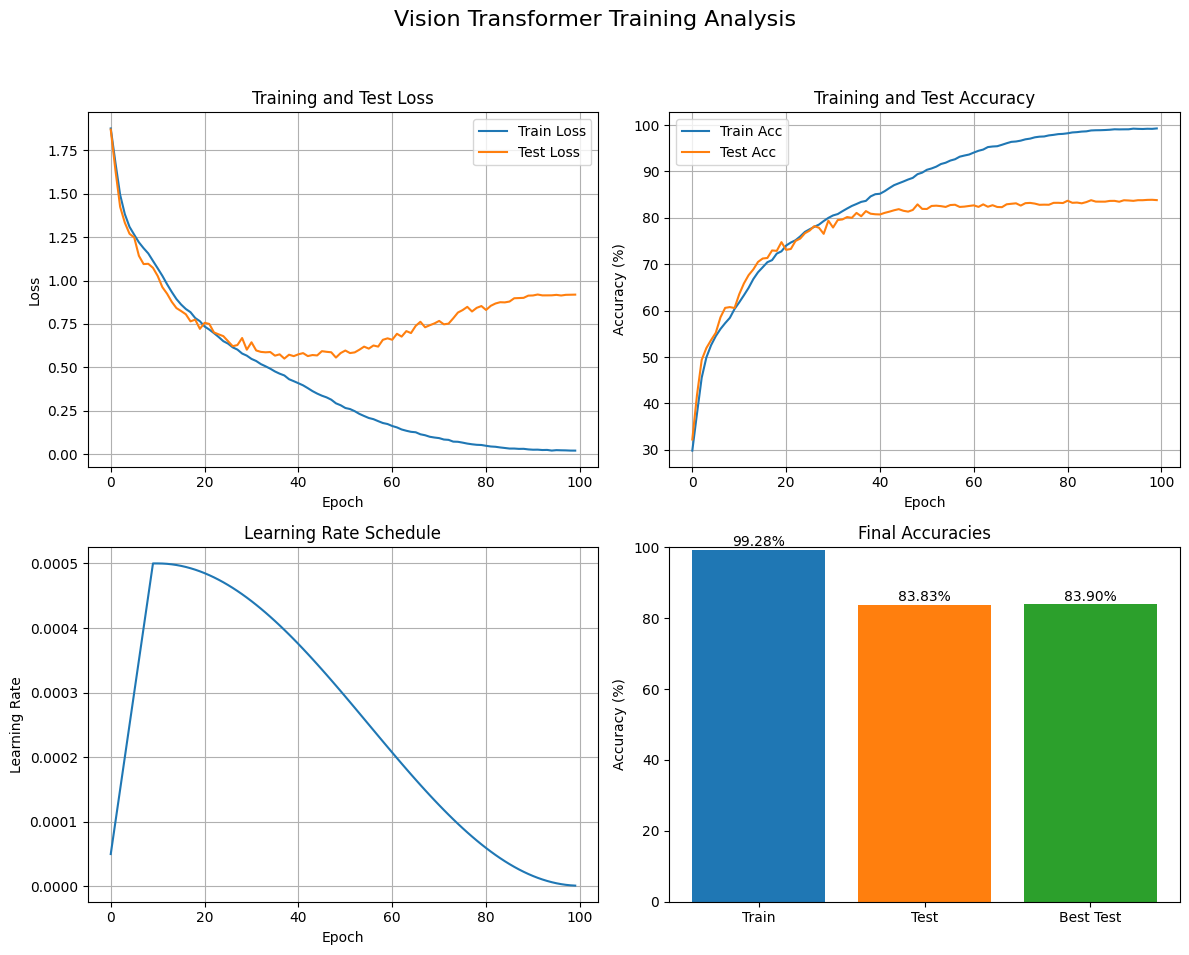

In [27]:
#@title 9. Visualization of Training Results
print("="*60)
print("STEP 8: VISUALIZING RESULTS AND ANALYSIS")
print("="*60)

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Vision Transformer Training Analysis', fontsize=16)


# Loss plot
axes[0, 0].plot(history['train_loss'], label='Train Loss')
axes[0, 0].plot(history['test_loss'], label='Test Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Test Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy plot
axes[0, 1].plot(history['train_acc'], label='Train Acc')
axes[0, 1].plot(history['test_acc'], label='Test Acc')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training and Test Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Learning rate plot
axes[1, 0].plot(history['lr'])
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].grid(True)

# Final accuracies bar plot
final_accs = [history['train_acc'][-1], history['test_acc'][-1], best_acc]
axes[1, 1].bar(['Train', 'Test', 'Best Test'], final_accs, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].set_title('Final Accuracies')
axes[1, 1].set_ylim([0, 100])
for i, v in enumerate(final_accs):
    axes[1, 1].text(i, v + 1, f'{v:.2f}%', ha='center')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [28]:
#@title 10. Ablation Studies and Analysis
print("="*60)
print("STEP 9: ABLATION STUDIES AND PERFORMANCE ANALYSIS")
print("="*60)

def create_small_vit(patch_size, depth, embed_dim):
    """Create a smaller ViT for ablation studies."""
    config_small = config.copy()
    config_small['patch_size'] = patch_size
    config_small['depth'] = depth
    config_small['embed_dim'] = embed_dim
    # We don't need to move to device for just counting params
    return VisionTransformer(**config_small)

# Analyze different configurations
print("\nModel Configuration Analysis:")
print("-" * 50)

configs_to_test = [
    {'name': 'Baseline (P4, D12, E192)', 'patch_size': 4, 'depth': 12, 'embed_dim': 192},
    {'name': 'Larger Patches (P8)', 'patch_size': 8, 'depth': 12, 'embed_dim': 192},
    {'name': 'Smaller Patches (P2)', 'patch_size': 2, 'depth': 12, 'embed_dim': 192},
    {'name': 'Shallow (D6)', 'patch_size': 4, 'depth': 6, 'embed_dim': 192},
    {'name': 'Deep (D16)', 'patch_size': 4, 'depth': 16, 'embed_dim': 192},
    {'name': 'Narrow (E128)', 'patch_size': 4, 'depth': 12, 'embed_dim': 128},
    {'name': 'Wide (E256)', 'patch_size': 4, 'depth': 12, 'embed_dim': 256},
]

for cfg in configs_to_test:
    model_test = create_small_vit(cfg['patch_size'], cfg['depth'], cfg['embed_dim'])
    params = sum(p.numel() for p in model_test.parameters())
    num_patches = (32 // cfg['patch_size']) ** 2
    print(f"{cfg['name']:<30} | Params: {params:>10,} | Patches: {num_patches:>4}")

STEP 9: ABLATION STUDIES AND PERFORMANCE ANALYSIS

Model Configuration Analysis:
--------------------------------------------------
Baseline (P4, D12, E192)       | Params:  5,362,762 | Patches:   64
Larger Patches (P8)            | Params:  5,381,194 | Patches:   16
Smaller Patches (P2)           | Params:  5,392,714 | Patches:  256
Shallow (D6)                   | Params:  2,693,578 | Patches:   64
Deep (D16)                     | Params:  7,142,218 | Patches:   64
Narrow (E128)                  | Params:  2,395,530 | Patches:   64
Wide (E256)                    | Params:  9,509,642 | Patches:   64


STEP 11: DETAILED FINAL EVALUATION


Computing predictions: 100%|██████████| 79/79 [00:06<00:00, 12.35it/s]


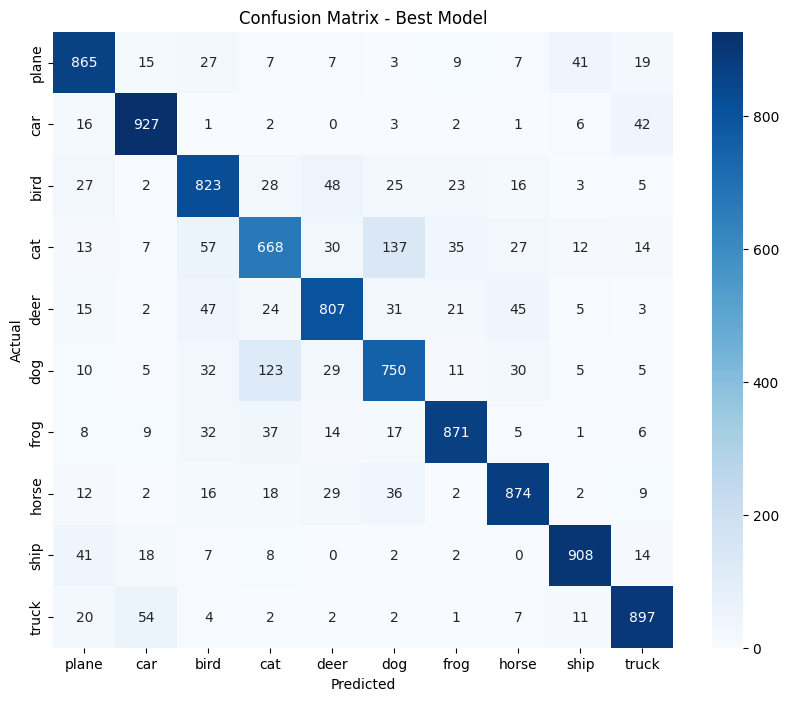


Per-Class Accuracy:
------------------------------
plane     : 86.50%
car       : 92.70%
bird      : 82.30%
cat       : 66.80%
deer      : 80.70%
dog       : 75.00%
frog      : 87.10%
horse     : 87.40%
ship      : 90.80%
truck     : 89.70%

Overall Test Accuracy: 83.90%


In [29]:
#@title 12. Final Evaluation (Confusion Matrix & Per-Class Accuracy)
print("="*60)
print("STEP 11: DETAILED FINAL EVALUATION")
print("="*60)

# Load best model
# Re-initialize model architecture and load state_dict
model = VisionTransformer(**config).to(device)
model.load_state_dict(torch.load('best_vit_cifar10.pth'))
model.eval()

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_predictions = []
all_targets = []

with torch.no_grad():
    for inputs, targets in tqdm(testloader, desc='Computing predictions'):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(targets.numpy())

# Create confusion matrix
cm = confusion_matrix(all_targets, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - Best Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Per-class accuracy
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print("\nPer-Class Accuracy:")
print("-" * 30)
for i in range(10):
    accuracy = 100 * class_correct[i] / class_total[i]
    print(f'{classes[i]:<10}: {accuracy:.2f}%')

overall_accuracy = 100 * sum(class_correct) / sum(class_total)
print(f'\nOverall Test Accuracy: {overall_accuracy:.2f}%')

# Performance Improvements and Key Insights
## Implemented Performance Improvements:
1. Data Augmentation:

- Random cropping with padding

- Random horizontal flipping

- Normalization with CIFAR-10 statistics

2. Architecture Optimizations:

- Patch size of 4x4 (good balance for 32x32 images)

- Depth of 12 transformer blocks

- Embedding dimension of 256 (scaled for CIFAR-10)

- 16 attention heads for multi-head attention

3. Training Techniques:

- AdamW optimizer with weight decay (0.05)

- Cosine annealing learning rate schedule with warmup

- Gradient clipping (max norm = 1.0)

- Dropout and embedding dropout for regularization

## Potential Further Improvements:
- MixUp or CutMix augmentation

- Label smoothing

- Stochastic depth (DropPath)

- Distillation from a larger model

- Ensemble multiple models

## Key Insights:
- Patch Size Trade-off: Smaller patches (2x2) give more fine-grained features but increase computation. Larger patches (8x8) are faster but may lose detail.

- Depth vs Width: Deeper models (more layers) can learn more complex representations but are harder to train. Wider models (larger embed_dim) have more capacity but require more data.

- Position Embeddings: Learnable position embeddings allow the model to understand spatial relationships between patches, crucial for vision tasks.

- CLS Token: The prepended CLS token aggregates information from all patches through self-attention, providing a global representation for classification